# Final

In this last section I will list my top four models and their respective performances on the validation set. Please note that only for my final model I will explain how the fitting procedure works in detail.

I consider a

1. Linear model using a subset of features
2. Deep neural network with dropout regularization
3. Two-stage random forest with feature selection
4. Gradient tree boosting (*the final model*)

If you only care about the final model please jump directly to subsection 4, in which I explain how the model is fit on a theoretical basis as well as how to implement it in Python. Note also that in the very last subsection I include a figure comparing the validation mean squared error for all of the presented models.

## Preliminaries

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

ROOT = Path(os.getcwd()).parent
np.random.seed(0)

In [2]:
df_train = pd.read_parquet(ROOT / "bld" / "train_simulated.parquet")
df_val = pd.read_parquet(ROOT / "bld" / "validate_simulated.parquet")

y_train = df_train["Y"]
X_train = df_train.drop("Y", axis=1)

y_val = df_val["Y"]
X_val = df_val.drop("Y", axis=1)

## 1. Linear Model Using a Subset of Features

Here I fit a simple two-step 3rd degree polynomial regression model to benchmark the machine learning methods from below. The procedure has two steps as I only consider the features $\{X_3, X_{12}, X_{38}\}$. This set of features was selected in the previous section using the recursive feature elimination strategy. However, basically all other feature selection strategies considered in the previous section selected a similar set of features.

In [3]:
relevant = [f"X{k}" for k in [3, 12, 38]]

XX_train = X_train[relevant]
XX_val = X_val[relevant]

poly = PolynomialFeatures(degree=3, include_bias=False)
XX_train = poly.fit_transform(XX_train)
XX_val = poly.transform(XX_val)

lm = LinearRegression(n_jobs=3)
lm.fit(XX_train, y_train)

prediction = lm.predict(XX_val)
mse_lm = mean_squared_error(y_val, prediction)
print(f"(Linear Model) MSE: {mse_lm}")

(Linear Model) MSE: 5.361621926612066


## 2. Deep Neural Network with Dropout Regularization

I fit a deep neural network using the popular [keras](https://keras.io/) library ({cite}`keras`) which provides an intuitive API for the powerful [tensorflow](https://www.tensorflow.org/) package ({cite}`tensorflow`). The neural network architecture is set using the ``build_regressor`` function. I choose an archtecture with 7 layers. For the first layer I choose 50 hidden nodes, for the second layer 25 hidden nodes and for all remaining layers I choose 10 hidden nodes. Moreover I use the so called [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function, which has been proven to outperform the classic sigmoid activation function in several ways, see for example {cite}`krizhevsky2017`. As overfitting is a big problem with deep networks I employ a popular technique called dropout regularization to mitigate this effect, see {cite}`srivastava2014`. Dropout leads to neurons in a layer being randomly deactivated for a single epoch during the backpropagation. This avoids neighboring neurons developing a strong dependency, which is said to mitigate overfitting.

***Note.*** I decide to use this specific architecture as I "learned" from the previous section that the main effects are sparse in the sense that most likely only very few features are relevant. However, I also realized from playing around with the linear model while watching the validation error that some effects must be non-linear. An architecture which reduces the nodes from the original 100 input dimensions to 50, then 25 and then 10, forces the network to select relevant features. And by using the additional 5 layers the network can potentially find non-linear signals.

***Remark.*** Since the gradient boosted tree presented below performs so well I did not consider many different architectures. I do believe that the neural networks should be able to perform comparably well if a better architecture is chosen.

In [4]:
N_COL = X_train.shape[1]
def build_regressor():
    regressor = Sequential()
    # first hidden layer
    regressor.add(Dense(units=50, activation="relu", input_dim=N_COL))
    regressor.add(Dropout(0.2))
    
    # second hidden layer
    regressor.add(Dense(units=25, activation="relu"))
    regressor.add(Dropout(0.2))
    
    # third to tenth hidden layer
    for _ in range(5):
        regressor.add(Dense(units=10, activation="relu"))
    
    # output layer
    regressor.add(Dense(units=1, activation="linear"))
    
    # compile model
    regressor.compile(optimizer="adam", loss="mean_squared_error")
    return regressor

In [5]:
nnet = KerasRegressor(
    build_fn=build_regressor, batch_size=128, epochs=200, verbose=0
)
nnet.fit(X_train, y_train)

prediction = nnet.predict(X_val)
mse_nnet = mean_squared_error(y_val, prediction)
print(f"(Neural Network) MSE: {mse_nnet}")

(Neural Network) MSE: 5.289789777325298


## 3. Two-stage Random Forest with Feature Selection

In this two stage procedure I first fit a random forest on the full set of features. I then consider the standard feature importance measure of random forests, which is automatically calculated from the fitting procedure. Using this I select the 30 *most* important features and fit another random forest on this subset of features.

***First Stage***

In [6]:
rf = RandomForestRegressor(
    n_estimators=250, 
    max_features=25, 
    max_depth=15,
    min_samples_leaf=100,
    bootstrap=True,
    n_jobs=3,
    random_state=1,
)
rf.fit(X_train, y_train.values)

std = np.std(
    [tree.feature_importances_ for tree in rf.estimators_], 
    axis=0
)
indices = np.argsort(rf.feature_importances_)[::-1]
relevant = [f"X{i+1}" for i in indices[:30]]

prediction = rf.predict(X_val)
mse_first_stage = mean_squared_error(y_val, prediction)
print(f"First stage MSE: {mse_first_stage}")

First stage MSE: 5.1615609346407565


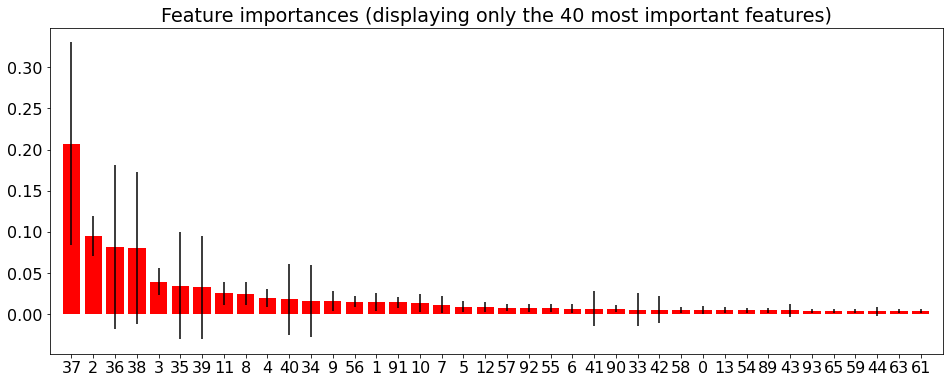

In [7]:
# plotting code: can be safely ignored
plt.rcParams.update({'font.size': 16, 'figure.figsize': (16, 6)})
cut = 40
x = range(X_train.shape[1])[:cut]
y = rf.feature_importances_[indices][:cut]
plt.figure()
plt.title(f"Feature importances (displaying only the {cut} most important features)")
plt.bar(x, y, color="r", yerr=std[indices][:cut], align="center")
plt.xticks(x, indices[:cut])
plt.xlim([-1, cut])
plt.show()

***Second Stage***

In [8]:
XX_train = X_train[relevant]
XX_val = X_val[relevant]

rf = RandomForestRegressor(
    n_estimators=250, 
    max_features=15, 
    max_depth=15,
    min_samples_leaf=100,
    bootstrap=True,
    n_jobs=3,
    random_state=1,
)
rf.fit(XX_train, y_train.values)

prediction = rf.predict(XX_val)
mse_rf = mean_squared_error(y_val, prediction)
print(f"(Random Forest) MSE: {mse_rf}")

(Random Forest) MSE: 5.120511556417796


## 4. Gradient tree boosting (*the final model*)

The final model I decided to use is a specific variant of a gradient boosted tree. The key concepts of this method are equivalent to the algorithm proposed in the seminal paper by Friedman, see {cite}`friedman2002`. The version I am using is implemented in the [catboost](https://catboost.ai/) package, which differs slightly from common other implementations. Next I will introduce the theoretical concept of gradient boosting with a particular focus on tree weak-learners. Afterwards I show how to fit a model using ``catboost``.

***Note.*** My final prediction submissions are made with the exact model specification as presented in below, but using the complete training data. The corresponding script can be found here [final_prediction.py](https://github.com/timmens/topics-project/blob/main/codes/final_prediction.py).


### Theory

I will first explain the general idea behind boosting and gradient boosting. Then I show how the general formulas simplify when using (regression) trees as base-learners. At last I illustrate how out-of-sample prediction loss may be improved by using ideas from stochastic gradient descent and regularization.

***Note.*** My notation and explaination is guided by {cite}`friedman2002` and {cite}`esl2001`.

---

**Notation and Preliminaries**

Assume we are given a data set $\{(x_i, y_i) : i=1,\dots,N\}$, with $x_i \in \mathbb{R}^p$ and $y_i \in \mathbb{R}$. These observations are assumed to be i.i.d. according to some joint distribution $\mathbb{P}_{xy}$. An important goal of statistical learning is to find a function $f^* : \mathbb{R}^p \to \mathbb{R}$ such that

\begin{align*}
f^* = \underset{f}{\text{argmin}} \, \mathbb{E}^{xy} \left [L(y, f(x)) \right],
\end{align*}
given some loss function $L$, where the expectation is taken over the joint distribution of $x$ and $y$ values.

As is very common in statistical learning, boosting is a procedure to approximate $f^*$ by an additive model of the form

\begin{align*}
f(x) = \sum_{m=0}^M \beta_m b(x; \gamma_m),
\end{align*}
where the $\beta_m$ denote expansion coefficients and $b(\cdot\,,\gamma) : \mathbb{R}^p \to \mathbb{R}$ denote the so called *base-learners* which are parameterized by $\gamma$. If feasible in general we would like to estimate the parameters by solving

\begin{align*}
\underset{\{\beta_m, \gamma_m\}_1^M}{\min}  \sum_{i=1}^N L\left(y_i, \sum_{m=0}^M \beta_m b(x_i; \gamma_m)\right).
\end{align*}

For a general loss function and base-learner, however, this optimization is computationally intractable. We will also see that there are other reasons why we would like to estimate the coefficients in a different fashion.

---

**General Concept**

A simple algorithm to approximate the coefficient estimates from above is to fit each tuple $(\beta_m, \gamma_m)$ in a stage-wise fashion. That is, one starts with an initial guess $f_0$ and then

for each $m=1,\dots, M$ do:
1. $(\beta_m, \gamma_m) = \underset{\beta, \gamma}{\text{argmin}} \, \sum_{i=1}^N L \left(y_i, f_{m-1}(x_i) + \beta b(x_i; \gamma) \right)$
2. $f_m(x) = f_{m-1}(x) + \beta_m b(x, \gamma_m)$.

This simplifies the optimization problem from above consideribly, but again, for general loss functions and base-learners step 1 can be hard to solve.

---

**Gradient Boosting**

Gradient boosting, as proposed in {cite}`friedman2000`, approximately solves the first step from above for differentiable loss functions using a three step procedure. In the $m$-th loop from above we do

1. $r_{im} := - \left[\frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}  \right]_{f(x) = f_{m-1}(x)}$
2. $\gamma_m = \underset{\gamma, \rho}{\text{argmin}} \, \sum_{i=1}^N \left(r_{im} - \rho b(x_i; \gamma) \right)^2$
3. $\beta_m = \underset{\beta}{\text{argmin}} \, \sum_{i=1}^N L \left(y_i, f_{m-1}(x_i) + \beta b(x_i; \gamma_m) \right)$.

That is, we first compute the gradient, whose entries we call *pseudo-residuals*, and then we fit a single base-learner using the least-squares method. Lastly we have to solve a general optimization problem, but only in a single variable, which can be done efficiently with state-of-the-art optimization algorithms.

With squared-error loss ($L(y, x) = \frac{1}{2}(y - x)^2$) the pseudo-residuals $r_{im}$ are equivalent to the actual residuals $r_{im} = y_i - f_{m-1}(x_i)$. This allows for the nice interpretation of the procedure that given any step $m$, we consider the deviations of the labels $y_i$ from our current estimate $f_{m-1}(x_i)$ and train a model to fit these deviations. I.e. in each iterations the model tries to improve the fit in the regions where the fit is worst. With other loss functions, say absolute-error loss ($L(y, x) = |y - x|$) we get $r_{im} = \text{sign}(y_i - f_{m-1}(x_i))$ and in the $m$-th step the base-learner is fit to simply predict the direction to which a sample deviates, which is more robust to outliers as it ignores the magnitude of the deviation.

---

**Gradient Tree Boosting**

A popular choice of base-learners are decision trees. When using trees as base learners some steps in the generic algorithm simplify and some can even be improved. First, let us formally define a tree. A regression tree with $J$ terminal-nodes is a function

\begin{align*}
T\left(x; \{\alpha_j, R_j\}_{j=1}^J \right) = \sum_{j=1}^J \alpha_j \mathbb{1}_{R_{j}}(x),
\end{align*}
where $\{R_j\}_{j=1}^J$ is a partition of the feature space $\mathbb{R}^p$. Strictly speaking, $J$ is also a parameter, however, it is usually considered a *hyper-parameter* which has to be chosen using prior information or via methods like cross-validation. 

Let us now consider the second step of the above algorithm. First note that optimizing over $\rho$ is irrelevant in the case of trees as we can always define $\tilde{\alpha}_j := \rho \alpha_j$. But then solving 2 is equivalent to solving

\begin{align*}
\{\alpha_{jm}, R_{jm}\}_{j=1}^J =: \gamma_m = \underset{\gamma}{\text{argmin}} \, \sum_{i=1}^N \left(r_{im} - T(x_i; \gamma) \right)^2
\end{align*}
For a given $J$ this combinatorial optimization problem is again computationally intractable, but there are many algorithms that can approximate the solution; see for example the CART algorithm in {cite}`esl2001`.

Henceforth say we have (approximately) solved the tree optimization problem (step 2) and are left to optimize for the constant $\beta_m$ (step 3). As will be seen, with trees we can even go one step further and choose an optimal value for each terminal-node region. Let $\gamma_m = \{\alpha_j, R_j\}_{j=1}^J$ be the fitted parameters from step 2. The next simplification when using trees stems from the fact the the $R_j$'s form a partition of the feature space. We can rewrite the sum over the individuals as a sum over the terminal-node regions, as a tree predicts the same value for each region. That is, step 3 becomes

\begin{align*}
\{\beta_{jm}\}_{j=1}^J = \underset{\beta_1,\dots,\beta_J}{\text{argmin}} \, \sum_{j=1}^J \sum_{x_i \in R_j} L \left(y_i, f_{m-1}(x_i) + \beta_j \right) \,,
\end{align*}
which can be solved for each region seperately. Note that we can write $L \left(y_i, f_{m-1}(x_i) + \beta_j \right)$ instead of $L \left(y_i, f_{m-1}(x_i) + \beta_j \alpha_j \right)$.

As an example, with squared error loss we would then get $\beta_{jm} = \text{mean}(y_i - f_{m-1}(x_i) : x_i \in R_{jm}) = \text{mean}(r_{im} : x_i \in R_{jm})$.

---

**Algorithm**

For the sake of clarity I illustrate the complete gradient tree boosting algorithm. This corresponds to Algorithm 10.3 (Gradient Tree Boosting Algorithm) in {cite}`esl2001` with minor modifications.

*Input*: $M$ (number of trees), $J$ (number of terminal nodes), $L$ (loss function), $\{(x_i, y_i)\}_{i=1}^N$ (training data).

1. $f_0 = \underset{\gamma}{\text{argmin}} \sum_{i=1}^N L(y_i, \gamma)$
2. For $m = 1, \dots, M$:
    - a) For $i=1,\dots,N$ compute $r_{im} := - \left[\frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}  \right]_{f = f_{m-1}}$
    - b) Fit a tree to $\{(x_i, r_{im})\}_{i=1}^N$ resulting in regions $\{R_{jm}\}_{j=1}^J$
    - c) For $j=1,\dots,J$ solve $\gamma_{jm} = \underset{\gamma}{\text{argmin}} \sum_{x_i \in R_{jm}} L(y_i, f_{m-1}(x_i) + \gamma)$
    - d) Update $f_m = f_{m-1} + \sum_{j=1}^J \gamma_{jm} \mathbb{1}_{R_{jm}}$
3. Return $f = f_M$

---

**Enhancements**

Until now we have not mentioned two key concepts used widely in the statistical and machine learning literature. *Injecting randomness*, which is used to decorrelate trees and therefore to avoid overfitting, and *regularization*, which is is also used to avoid overfitting.

- ***Injecting Randomness.***
From empirical experience it has been seen that methods like bagging {cite}`breiman96` and random forests {cite}`breiman2001` outperform similar algorithms that do not explicitly make use of randomness. Similarly stochastic gradient descent is considered superior to the classical gradient descent algorithm when used in a machine learning setting; see {cite}`bottou2016`. The easiest way to inject randomness to the gradient boosting algorithm is described in {cite}`friedman2002`. In the second step of the above algorithm we simply consider a randommly shuffled subset of the data of size $N' < N$. On top of potentially improving out-of-sample fit, this can lead to significantly shorter training times. 

- ***Regularization.***
Similarly as injecting randomness, a popular technique to avoid overfitting is regularization. Especially shrinkage methods like ridge regression and lasso have gained immense popularity; see for example {cite}`slws2015`. An immediate enhancement to the above algorithm is to include a shrinkage paramater $0 < \nu \leq 1$ in the updating step, which is usually called the *learning rate*. In step 2.d) we then modify the equation slightly to get
$f_m = f_{m-1} + \nu \sum_{j=1}^J \gamma_{jm} \mathbb{1}_{R_{jm}}$.
It was found empirically that small values of the learning rate, $\nu < 0.1$, lead to better generalization; see {cite}`friedman2000`.

---

**Catboost**

Catboost is an open-source library for gradient boosting on decision trees. Its implementation differs slighty from the above algorithm. As of right now it outperforms or ties with most other open-source boosting libraries such as [LightGBM](https://lightgbm.readthedocs.io/en/latest/), [XGBoost](https://xgboost.readthedocs.io/en/latest/) and [H2O](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html); see the benchmarks [here](https://catboost.ai/#benchmark). Next I will list the main differences and refer to the respective papers for reference.

- ***Categorical Features.***
The main new feature in ``catboost`` is the clever support of categorical features. Decision trees cannot usally deal with categorical features with more than 2 states. (This is of course because the binary relation "$\leq$" must not be defined on the discrete space.) A common approach is the so called *one-hot* encoding, where we introduce a new binary feature for the activation of each state. If the feature set includes many categorical features and the state space is large for many, then one-hot encoding can blow up the dimensionality of the problem to a problematic extent. Another approach is to use target statistics, in which we try to map the categorical features to numerical ones. Consider a categorical feature and let it be denoted by the $k$-th feature. Frequently the target statistic is chosen as to approximate the conditional mean, i.e. $\tilde{x}_{ik} \approx \mathbb{E}_{xy}\left[y \mid x = x_{ik}\right]$. See {cite}`dorogush2018` for details.

- ***Unbiased Gradients.***
It is argued in {cite}`dorogush2017` that gradient boosting suffers from a bias generated by using biased gradient estimates, which leads to overfitting. Theorem 1 in {cite}`prokhorenkova2017` proves this result under some conditions on the algorithm. A solution to avoid this effect is proposed in the above papers and implemented in ``catboost``.

- ***Oblivious Trees.***
The base-learner used in ``catboost`` is not a regular decision tree but an *oblivious tree*, sometimes also called a *decision table*. The main difference to regular decision trees is that all nodes on a given level have to split on the same feature and the same point. This is why oblivious trees are usually longer than standard trees since they need more levels to capture non-linearities. Recently this form of tree structure has captured attention in the machine learning community and is being used often together with gradient boosting machines; see for example {cite}`yin2017`, {cite}`ferov2016` and {cite}`popov2019`. For a general definition of oblivious trees see {cite}`kohavi1995`.

---

***Final Remark on the Theory.***

In the above I have talked about the (historical) development of the gradient tree boosting algorithm, however, I have not explained why boosting achieves the goal of function approximation so well. Given the standard squared-error loss it is known that the function $f^*$ which minimizes the expected loss is the conditional expectation $f^*(x) = \mathbb{E}_{xy}\left[y \mid x=x\right]$. Do we have any guarantee that boosting is at least point wise consistent then? Specific variants of the boosting algorithm and consistency thereof have been of interest in the recent literature; see {cite}`biau2017` or {cite}`lu2019`. For the very first boosting algorithm (which was actually used for classification) {cite}`platt2007` show consistency under regularity conditions. At last {cite}`yu2005` consider consistency of the boosting algorithm under early-stopping.

### Implementation / Application

In [9]:
gbt = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.01, 
    depth=5,
    loss_function="RMSE",
    random_state=1,
)
gbt.fit(X_train, y_train, verbose=False)

prediction = gbt.predict(X_val)
mse_gbt = mean_squared_error(y_val, prediction)
print(f"(Catboost) MSE: {mse_gbt}")

(Catboost) MSE: 5.048105271497743


## MSE Comparison

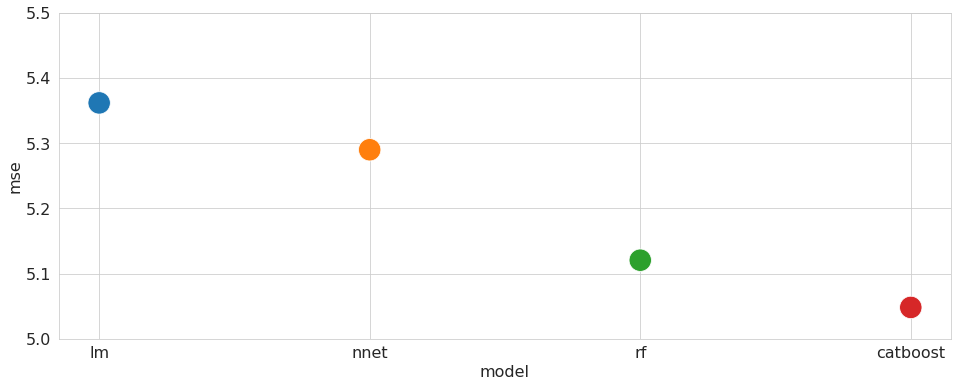

In [10]:
models = ["lm", "nnet", "rf", "catboost"]
mses = [mse_lm, mse_nnet, mse_rf, mse_gbt]
data = pd.DataFrame(zip(models, mses), columns=["model", "mse"])

sns.set_style("whitegrid")
plt.ylim(5, 5.5)
_ = sns.scatterplot(
    x="model", y="mse", data=data, hue="model", s=500, legend=None
)